# Create CI/CD automation using a Git source


This example shows how to create a project in MLRun for CI/CD automation based on a remote source, for example, Git. 
The process is equivalent for using tar.gz, zip archive files.

The flow covers these steps to create aCI/CD project in MLRun:
1. Create an MLRun project
2. Set a project source: remote or archive
3. Run and set MLRun functions using the Git source code
4. Run and set an MLRun workflow
5. Set and register MLRun artifacts
6. Create and save the project YAML 
7. Push and manage the git repo or archive file

## Before you start

Install mlrun. I MLRun is not installed use ``pip install mlrun==<mlrun server version>`` or ``sh align_mlrun.sh`` (the default mlrun installer - automatically installs the server version).

In [1]:
import mlrun

Before running this notebook, clone the git repo to your local machine.

In [2]:
# delete the clone folder if exists
!rm -rf ./clone

In [3]:
# clone repo to your local machine
!git clone https://github.com/GiladShapira94/example-ci-cd.git ./clone

Cloning into './clone'...
remote: Enumerating objects: 209, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 209 (delta 118), reused 129 (delta 53), pack-reused 0
Receiving objects: 100% (209/209), 162.20 KiB | 1.65 MiB/s, done.
Resolving deltas: 100% (118/118), done.


## Creating a project

MLRun provides three options for creating or loading a project:

1. [get_or_create_project](../api/mlrun.projects.html#mlrun.projects.get_or_create_project): use this method to load a project from MLRun DB.
or optionally load it from a yaml/zip/tar/git template, and create a new project if doesn't exist
2. [new_project](../api/mlrun.projects.html#mlrun.projects.new_project): 
Create a new MLRun project, optionally load it from a yaml/zip/tar/git template.
3. [load_project](../api/mlrun.projects.html#mlrun.projects.load_project): Load an MLRun project from yaml/zip/tar/git/dir or from MLRun db.

```{admonition} Note
To load a project you must have a project.yaml file that may include all the relevant metadata such as function, workflows, and artifacts, in your repo/archive file or to have the project stored in the MLRun DB.
```

### Creating a project

**Prerequisites**:
1. Your repo or archive file contains python code files that are ready to run.
2. You either cloned your repo or extracted your archive file to your local machine.

In [4]:
# create a new project or load it from DB
project = mlrun.get_or_create_project(name='new-ci-cd-proj',context='./clone',user_project=True)

> 2023-05-17 09:04:46,772 [info] loaded project new-ci-cd-proj from MLRun DB


**name** - project name

**context** - project local directory path (default value = "./")

When you create a new project, MLRun creates a light project YAML, for example: 
````
kind: project
metadata:
  name: new-ci-cd-proj
  created: '2022-06-30T09:41:05.612000'
spec:
  functions: []
  workflows: []
  artifacts: []
  desired_state: online
status:
  state: online
````

**Secrets** - when working with a private repo you need to provide a Git token as a secret. You can set it using the MLRun SDK or MLRun UI, for example:
```
# when loading from a private repo
project = mlrun.get_or_create_project(name='new-ci-cd-proj',context='./',init_git=True,secrets={"GIT_TOKEN":<github-token>})

# when running functions in a project from a private repo
project.set_secrets({"GIT_TOKEN":<github-token>}
```

### Set a project source, either remote or archive 

To point the project to a specific source, set a project source using the {py:class}`mlrun.projects.MlrunProject.set_source` 
method. In addition, you can set the flags: 
- `pull_at_runtime`:  The MLRun function pulls the source code directly from Git at runtime.
- `load_source_on_run`: load the archive code into the container at runtime (and not at build time)
(e.g `load_source_on_run`) flag value and the project working dir.

 

This method adds the source, pull_at_runtime and the project working dir to the project.yaml and will copy those values to the functions spec when setting with_repo=True in the project.set_function method (will explain better in details), when running functions on the runtime/cluster (local=False) it will run the code files from the remote source.

```{admonition} Note
Add the git branch or refs to the source e.g.: 'git://url/org/repo.git#<branch-name or refs/heads/..>'
```

In [5]:
source = 'git://github.com/GiladShapira94/example-ci-cd.git#master'

In [6]:
project.set_source(source=source,pull_at_runtime=True)

**pull_at_runtime**
- `=True`: code is loaded in runtime to the Kubernetes pod. This options is better for debugging.
- `=False`: code is added to the image during build or function deployment. This option is better for production. 
When using this option, you need to build the function before running it using the {py:class}`mlrun.projects.MlrunProject.build_function` method. You can use this option to build a new image based 
on your job requirements or custom attributes.

### Run and set MLRun functions using git source code

In General for the first time you are working with a remote or an archive source code e.g git or zip file with MLRun, the first thing you want to do is to clone or extract your files to the project context to start developing and run your function in MLRun (for running function in local your files must be stored in the project context folder e.g ./project-context on your local machine).

If you have files that are allready competibile to run with MLRun, you do not need to clone or extract the files.

#### Set MLRun functions to the project

To set the functions definitions, use the {py:class}`mlrun.projects.MlrunProject.set_function` method.

You can set the functions metadata in the project YAML, for example: 
function source (YAML, py, ipynb, function object), name of the function, function handler, function image, function kind and function requirmnets.

```{admonition} Note
The code source file is usuallt stored under a folder named `./src` in the project context e.g `./project-context/src/data_fetch.py`

#### Using project source source

After your first development you would want use your project source to run your function on your cluster (when running from remote the function will run the files that stored in your repo or archive files), You can see below the examples:

1. Clone and extract the code files and use the local files to run functions in local (for developing) and use the remote source for running your functions on runtime/cluster, to do this add with_repo=True in the set_function method.
```
project.set_function(func='function.py
    name="training", handler="model_training",
    image="mlrun/mlrun", kind="job",with_repo=True
)
```
2. Run function from remote source (this approach does not support running function in local), to do this add with_repo=True and use the relative handler (folder_name.file_name.function_handler) to point to the python code file.
```
project.set_function(name="training", 
    handler="function.model_training",
    image="mlrun/mlrun", kind="job",with_repo=True
)
```

In this notebook we shows how to set function using the first option

**Note -** in those examples you will need to push or create a new archive file after every code change for those changes to take affect when running function in your cluster. 

> Set the with_repo=True to add the entire repo code into the destination container during build or run time. 

> When using with_repo=True the functions need to be deployed (function.deploy()) to build a container, unless you set project.set_source(source=source,pull_at_runtime=True) which instructs MLRun to load the git/archive repo into the function container at run time and do not require a build (this is simpler when developing, for production it’s preferred to build the image with the code)


**Fetch Data function**

In [7]:
# Set data_fetch function to the project.yaml file
project.set_function(func='./src/data_fetch.py',name='data-fetch',handler='data_fetch',kind='job',image='mlrun/mlrun',with_repo=True,tag="v3")

**Note -** I added a tag value, we will use that value after we complete our development as the git tag for the realese, this value need to be added manually to the function.

**Run Fucntion**

* You can use [project.get_function](https://docs.mlrun.org/en/latest/api/mlrun.projects.html?highlight=get_function#mlrun.projects.MlrunProject.get_function) method, to get the function object after you set the function in the project.

**Note -** The get_function allows the user to get function object and change the funciton spec for example the function resources and, then when the user will run the function it will run with those those changes (those changes are stored in the project object cache)
```
data_fetch_func = mlrun.get_function('data-fetch')
data_fetch_func.with_requests(mem='1G',cpu=3)
data_fetch_run = project.run_function('data-fetch')
```

* For running functions you can use the [project.run_function](https://docs.mlrun.org/en/latest/api/mlrun.projects.html?highlight=run_function#mlrun.projects.run_function) method, 
This method allows you to run a MLRun jobs locally and on the runtime/cluster as long as there is no requirments ( if there is any requirments you will need to build a new image before you run a function).


**Run funciton in local**

Use the code files from you project context folder on your local machine

In [8]:
data_fetch_run = project.run_function(function='data-fetch',returns=['train-dataset','test-dataset'],local=True)

> 2023-05-17 09:04:46,993 [info] Storing function: {'name': 'data-fetch-data-fetch', 'uid': 'a6e5cc8f573e41f6ae6ef1c049b6e50a', 'db': 'http://mlrun-api:8080'}


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
new-ci-cd-proj-shapira,...49b6e50a,0,May 17 09:04:47,completed,data-fetch-data-fetch,v3io_user=shapirakind=owner=shapirahost=jupyter-shapira-7fc985f9db-cp8x9release=v3,,,,train-datasettest-dataset


> 2023-05-17 09:04:50,355 [info] run executed, status=completed: {'name': 'data-fetch-data-fetch'}


**Run function in remotte - on your cluster**

Use the code files from the remote project source

In [9]:
data_fetch_run = project.run_function(function='data-fetch',returns=['train-dataset','test-dataset'],local=False)

> 2023-05-17 09:04:50,395 [info] Storing function: {'name': 'data-fetch-data-fetch', 'uid': '860b9700cd3f4724a0669cb7c9732beb', 'db': 'http://mlrun-api:8080'}
> 2023-05-17 09:04:50,649 [info] Job is running in the background, pod: data-fetch-data-fetch-qd874
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
new-ci-cd-proj-shapira,...c9732beb,0,May 17 09:04:54,completed,data-fetch-data-fetch,v3io_user=shapirakind=jobowner=shapiramlrun/client_version=1.3.1-rc5mlrun/client_python_version=3.7.6host=data-fetch-data-fetch-qd874release=v3,,,,train-datasettest-dataset


> 2023-05-17 09:05:03,834 [info] run executed, status=completed: {'name': 'data-fetch-data-fetch'}


In [10]:
data_fetch_run.outputs

{'train-dataset': 'store://artifacts/new-ci-cd-proj-shapira/data-fetch-data-fetch_train-dataset:860b9700cd3f4724a0669cb7c9732beb',
 'test-dataset': 'store://artifacts/new-ci-cd-proj-shapira/data-fetch-data-fetch_test-dataset:860b9700cd3f4724a0669cb7c9732beb'}

In [11]:
data_fetch_run.artifact('train-dataset').as_df().sample(3)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,label
14,0.655400,1.357176,-0.380252,2.236612,0.102893,-0.038678,0.101061,1.555770,1.116734,0.146883,...,-2.132336,0.739735,0.452615,0.299427,0.683967,-0.089078,0.609046,-0.895865,-0.578405,1
27,0.834107,0.572216,-0.872751,0.519342,-1.101798,0.259935,0.398852,-0.299485,0.821154,0.018271,...,-1.634293,-0.618584,1.354337,-1.136238,1.248243,-0.593805,0.266741,1.180665,1.212383,1
79,-2.040370,3.446461,-0.269668,-0.875862,1.347329,1.412033,0.764714,2.161531,0.390874,-0.900138,...,-0.904111,2.640541,-2.483898,-1.619484,-3.676358,0.704040,-3.192003,1.669527,0.782062,1


**Train function**

In [12]:
project.set_function(func='./src/train.py',name='train',handler='train',kind='job',image='mlrun/mlrun',with_repo=True,tag="v3")

In [13]:
train_run = project.run_function(function='train',inputs={'train_data':data_fetch_run.outputs['train-dataset'],'test_data':data_fetch_run.outputs['test-dataset']})

> 2023-05-17 09:05:04,113 [info] Storing function: {'name': 'train-train', 'uid': '423d664e6e684b1fb9acc9e62189d5b4', 'db': 'http://mlrun-api:8080'}
> 2023-05-17 09:05:04,362 [info] Job is running in the background, pod: train-train-7z8z8
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
new-ci-cd-proj-shapira,...2189d5b4,0,May 17 09:05:08,completed,train-train,v3io_user=shapirakind=jobowner=shapiramlrun/client_version=1.3.1-rc5mlrun/client_python_version=3.7.6host=train-train-7z8z8release=v3,train_datatest_data,,accuracy=0.85f1_score=0.8421052631578948precision_score=1.0recall_score=0.7272727272727273,feature-importancetest_setconfusion-matrixroc-curvescalibration-curvemodel


> 2023-05-17 09:05:25,610 [info] run executed, status=completed: {'name': 'train-train'}


**Serving Function**

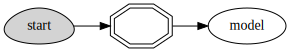

In [14]:
# Create a serving function object
serving = mlrun.new_function(name="serving", kind="serving", image="mlrun/mlrun",tag="v3")

# Add a model to the model serving function object
serving.add_model(key='model',model_path=train_run.outputs["model"], class_name='mlrun.frameworks.sklearn.SklearnModelServer')

# plot the serving graph
serving.spec.graph.plot(rankdir="LR")

In [15]:
# save the function spec into a .yaml file and register it in the project
serving.export(target=f"./{project.context}/function_spec/serving.yaml")
project.set_function(func="./function_spec/serving.yaml", name="serving")

> 2023-05-17 09:05:25,815 [info] function spec saved to path: ././clone/function_spec/serving.yaml


#### Speciel Cases

When creating a CI/CD project there are speciel cases you need to take in consider, please check the list below:

1. When creating a serving function the function spec contain metadata of the function steps or the serving function models.

    becuase of it you need to create a function.yaml file by using the [export()](https://docs.mlrun.org/en/latest/api/mlrun.runtimes.html?highlight=export#mlrun.runtimes.BaseRuntime.export) method that export the function object to a yaml file (will be saved in function_spec folder), and then set the function with this yaml file, with this approach all the function spec will be saved for future deployments.

For Example:
````
<function object>.export('./model_training.yaml')
````

````
project.set_function(
    func="training.yaml",name='training',with_repo=True,kind='serving')
````
2. In addition to the first point if you want to change the defualt funciton spec values e.g resources, node-selector and more, and want to make this change constant you will need to create a yaml function file and use the yaml function in the set_fucntion method.
3. When set a nuclio function the function handler is a combination of the file_name::function_handler, for example:
```
project.set_function(name='nuclio',handler='multi:multi_3',kind='nuclio',image='mlrun/mlrun',with_repo=True)
```

* For deploy remote function e.g serving and nuclio kinds you can use [project.deploy_function](https://docs.mlrun.org/en/latest/api/mlrun.projects.html?highlight=deploy_function#mlrun.projects.deploy_function) method.

In [16]:
serving_func = project.deploy_function(function='serving',models=[{'key':'model','model_path':train_run.outputs["model"], 'class_name':'mlrun.frameworks.sklearn.SklearnModelServer'}])

> 2023-05-17 09:05:25,839 [info] Starting remote function deploy
2023-05-17 09:05:26  (info) Deploying function
2023-05-17 09:05:26  (info) Building
2023-05-17 09:05:26  (info) Staging files and preparing base images
2023-05-17 09:05:26  (info) Building processor image
2023-05-17 09:06:26  (info) Build complete
2023-05-17 09:06:34  (info) Function deploy complete
> 2023-05-17 09:06:37,264 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-new-ci-cd-proj-shapira-serving-v3.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['new-ci-cd-proj-shapira-serving-v3-new-ci-cd-proj-shapira.default-tenant.app.cust-cs-il-3-5-2.iguazio-cd2.com/']}


In [17]:
my_data = '''{"inputs":[[-0.60150011,  0.51150308,  0.25701239, -1.51777297, -1.82961288,
         0.22983693, -0.40761625,  0.82325082,  1.1779216 ,  1.08424275,
        -0.7031145 , -0.40608979, -0.36305977,  1.28075006,  0.94445967,
         1.19105828,  1.93498414,  0.69911167,  0.50759757,  0.91565635]]}'''

In [18]:
serving_func.function.invoke('/',my_data)

> 2023-05-17 09:06:37,342 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-new-ci-cd-proj-shapira-serving-v3.default-tenant.svc.cluster.local:8080/'}


{'id': '8ca4f4ef-7765-4d50-8a43-1e77a15e433f',
 'model_name': 'model',
 'outputs': [1]}

### Run and set MLRun workflow

After you complete developing your functions (in our example we build 3 function - data_fetch, training and serving) we will want to create a workflow that run those function one by one, for more information about workflow and an example of a workflow.py file,you can check  - [link](https://docs.mlrun.org/en/stable/projects/build-run-workflows-pipelines.html).

**Set workflow**

To set a workflow to a project you need to use [project.set_workflow](https://docs.mlrun.org/en/stable/api/mlrun.projects.html?highlight=set_workflow#mlrun.projects.MlrunProject.set_workflow) method, this method add or update a workflow, specify a name and the code path in the project.yaml file

In this example we added a workflow named main that point to a file located ./< project-context >/src/workflow.py

In [19]:
project.set_workflow('main','./src/workflow.py')

To run the workflow you can use [project.run](https://docs.mlrun.org/en/stable/api/mlrun.projects.html?highlight=run#mlrun.projects.MlrunProject.run) method, this method allow you to run a workflow or schedule workflow using kubeflow pipelines by specifing the workflow name or the workflow file path.
This workflow will run all the functinos you set in to the project

**Run workflow**

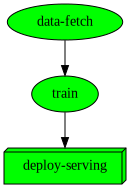

uid,start,state,name,parameters,results
...d1cc13bd,May 17 09:07:23,completed,train,,accuracy=1.0f1_score=1.0precision_score=1.0recall_score=1.0
...2476131c,May 17 09:06:53,completed,data-fetch,,


626a345a-b67f-4eb0-9a3b-4850185ada10

In [20]:
# run workflow named main and wait for pipeline completion (watch=True)
project.run('main',watch=True,engine="remote:kfp")

**Note -** for setting engine for remote running use 'remote:local' or 'remote:kfp'.

**Run Schedule workflow**

For more inforation about scheduling workflows, please check this [link](https://docs.mlrun.org/en/latest/concepts/scheduled-jobs.html)

In [21]:
project.run('main',watch=True,schedule='0 * * * *')

> 2023-05-17 09:09:34,482 [warning] WARNING!, you seem to have uncommitted git changes, use .push()
> 2023-05-17 09:09:34,485 [info] executing workflow scheduling 'workflow-runner-main' remotely with kfp engine
> 2023-05-17 09:09:34,489 [info] Storing function: {'name': 'main', 'uid': '88a2eecd5cd14c339529f2c7ced3a011', 'db': 'http://mlrun-api:8080'}
> 2023-05-17 09:09:34,854 [info] task schedule modified: {'schedule': '0 * * * *', 'project': 'new-ci-cd-proj-shapira', 'name': 'main'}


### Set and register MLRun artifacts

For set artfiacts to a project you can use the [project.set_artifact](https://docs.mlrun.org/en/stable/api/mlrun.projects.html?highlight=set_artifact#mlrun.projects.MlrunProject.set_artifact) method, this method allows you to add/set an artifact in the project spec (will be registered on load).

In general you will want to use this method when you will want to register an artifact when loading a project for example:
* Developed a model artifact in development system and you want to use this model file in production
* Artifacts you want to register by defualt when you load or create a project

**Note -** To register artifact between difrrent environments e.g dev and prod you must upload your artifacts to a remote storage e.g s3, you can change your project artifact path using mlrun or mlrun ui
```
project.artifact_path='s3:<bucket-name/..'
```

**Set a model artifact**

In [22]:
# get model obejct to register
model_obj = project.get_artifact('model')

In [23]:
#print target path
print(model_obj.target_path)

v3io:///projects/new-ci-cd-proj-shapira/artifacts/626a345a-b67f-4eb0-9a3b-4850185ada10/train/0/model/


In [24]:
#print model file
model_obj.model_file

'model.pkl'

In [25]:
# set model artifact to the project
project.set_artifact(key='model-test',artifact=mlrun.artifacts.ModelArtifact(model_file=model_obj.model_file),target_path=model_obj.target_path)

**Note -** by default the artifact type is equal to mlrun.artifacts.Artifact() for specifing difrrent types you need to use the relvant artifact object (then you can specify specific parameters to the artifcat object type), see below list:
```
    "dir": mlrun.artifacts.DirArtifact,
    "link": mlrun.artifacts.LinkArtifact,
    "plot": mlrun.artifacts.PlotArtifact,
    "chart": mlrun.artifacts.ChartArtifact,
    "table": mlrun.artifacts.TableArtifact,
    "model": mlrun.artifacts.ModelArtifact,
    "dataset": mlrun.artifacts.DatasetArtifact,
    "plotly": mlrun.artifacts.PlotlyArtifact,
    "bokeh": mlrun.artifacts.BokehArtifact,
```

**Spicial Cases -**
* When MLRun creating an artifact there are values that are proccesed in runtime e.g dataset preview or model metrics, those values are stored in the artifact spec, if you wish to store the artifact spec for registring the artifact with those values you will need to export the artifcat object to a folder named ./artifacts and set the artifact using the artifact.yaml file, see below example:

```
model_obj = project.get_artifact('model')
model_obj.export(./artifact/model_artifact.yaml)
project.set_artifact(key='model',artifact='./model_artifact.yaml')
```


### Create and save project YAML

The project YAML contains metadata about the project for example you can see that the project yaml contains all the function we set to the project, the artifact and the workflow, and then when you will load the project it will loaded with all those functions, artifact and workflow.

In general MLRun uses this metadata to create objects for example functions objects and then use those objects to run the functions.

In [26]:
print(project.to_yaml())

kind: project
metadata:
  name: new-ci-cd-proj-shapira
  created: '2023-05-17T08:51:02.127000'
spec:
  functions:
  - url: ./src/data_fetch.py
    name: data-fetch
    kind: job
    image: mlrun/mlrun
    handler: data_fetch
    with_repo: true
    tag: v3
  - url: ./src/train.py
    name: train
    kind: job
    image: mlrun/mlrun
    handler: train
    with_repo: true
    tag: v3
  - url: ./function_spec/serving.yaml
    name: serving
  workflows:
  - path: ./src/workflow.py
    name: main
  artifacts:
  - kind: model
    metadata:
      project: new-ci-cd-proj-shapira
      key: model-test
    spec:
      target_path: v3io:///projects/new-ci-cd-proj-shapira/artifacts/626a345a-b67f-4eb0-9a3b-4850185ada10/train/0/model/
      model_file: model.pkl
    status:
      state: created
  conda: ''
  source: git://github.com/GiladShapira94/example-ci-cd.git#master
  origin_url: git://github.com/GiladShapira94/example-ci-cd.git#refs/heads/master
  load_source_on_run: true
  desired_state: onl

To export the project content to yaml file (will be saved in the project context) and save project in database use the [project.save](https://docs.mlrun.org/en/latest/api/mlrun.projects.html?highlight=save#mlrun.projects.MlrunProject.save) method.

In [27]:
project.save()

### Push and Manage your git repo or archive file

**Create a git remote**

If you do not clone any files and you do not have any git remotes configured in your local folder you can use [project.create_remote](https://docs.mlrun.org/en/stable/api/mlrun.projects.html?highlight=create_remote#mlrun.projects.MlrunProject.create_remote) this method creates a git remote and add the remote to the project as the project source.

for exmaple:
```
project.create_remote(url='https://github.com/mlrun/example-ci-cd.git',name='mlrun-remote',branch='master')
```

**Push changes to git repo**

After you made changes in your code you will want to push your project context to GitHub repo, for this you can use [project.push](https://docs.mlrun.org/en/stable/api/mlrun.projects.html?highlight=push#mlrun.projects.MlrunProject.push)
```
project.push(branch='master',message='update',add=['project.yaml','./src/data_fetch.py','./src/serving.yaml','./src/train.py','./src/workflow.py'])
```

### Done! 
**Now you have a project YAML for CI/CD Automation  - Later we will demostrate how to load a project and use this Project YAML**